<a href="https://colab.research.google.com/github/lululxvi/deepxde/blob/master/examples/Lorenz_inverse_forced_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

This notebook aims at the identification of the parameters of the modified Lorenz attractor (with exogenous input)

Built upon: 
* Lorenz attractor example from DeepXDE (Lu's code)
* https://github.com/lululxvi/deepxde/issues/79
* kind help from Lu, greatly acknowledged

# Install lib and imports

In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow"""
!pip install deepxde

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import re
import numpy as np
import requests
import io
import matplotlib.pyplot as plt

import deepxde as dde
from deepxde.backend import tf

import scipy as sp
import scipy.interpolate as interp
from scipy.integrate import odeint


     |████████████████████████████████| 71kB 2.2MB/s 
     |████████████████████████████████| 860kB 8.7MB/s 
  Created wheel for salib: filename=SALib-1.3.11-py2.py3-none-any.whl size=729665 sha256=959eb24383de6204e4fb3a66a5e7d8ee7ab00adb5e306e70995ee8d6dac9a325
  Stored in directory: /root/.cache/pip/wheels/62/ed/f9/a0b98754ffb2191b98324b96cbbeb1bd5d9598b39ab996b429
Successfully built salib
Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


# Generate data

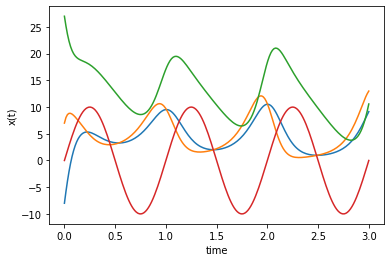

(200, 1)

In [ ]:
# true values, see p. 15 in https://arxiv.org/abs/1907.04502
C1true = 10
C2true = 15
C3true = 8 / 3

# time points
maxtime = 3
time = np.linspace(0, maxtime, 200)
ex_input = 10 * np.sin(2 * np.pi * time)  # exogenous input

# interpolate time / lift vectors (for using exogenous variable without fixed time stamps)
def ex_func(t):
    spline = sp.interpolate.Rbf(
        time, ex_input, function="thin_plate", smooth=0, episilon=0
    )
    # return spline(t[:,0:])
    return spline(t)


# function that returns dy/dt
def LorezODE(x, t):  # Modified Lorenz system (with exogenous input).
    x1, x2, x3 = x
    dxdt = [
        C1true * (x2 - x1),
        x1 * (C2true - x3) - x2,
        x1 * x2 - C3true * x3 + ex_func(t),
    ]
    return dxdt


# initial condition
x0 = [-8, 7, 27]

# solve ODE
x = odeint(LorezODE, x0, time)

# plot results
plt.plot(time, x, time, ex_input)
plt.xlabel("time")
plt.ylabel("x(t)")
plt.show()

time = time.reshape(-1, 1)
time.shape


# Perform identification

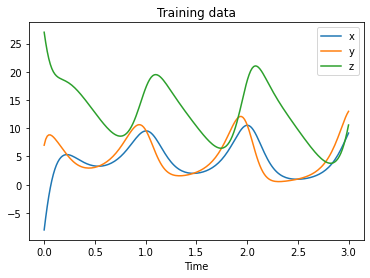

Compiling model...
Building feed-forward neural network...
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
'build' took 0.074330 s

'compile' took 1.289168 s

Initializing variables...
Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.16e-01, 1.51e-01, 5.04e+01, 6.40e+01, 4.90e+01, 7.29e+02, 2.70e+01, 3.29e+01, 2.07e+02]    [1.16e-01, 1.51e-01, 5.04e+01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1000      [5.36e+00, 3.01e+00, 7.93e+00, 3.42e+01, 6.84e-03, 2.17e+00, 2.97e+01, 1.55e+01, 2.68e+01]    [5.36e+00, 3.01e+00, 7.93e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2000      [9.25e+00, 2.24e+00, 3.39e+00, 1.85e+01, 3.10e-01, 7.63e-01, 2.82e+01, 2.24e+01, 2.31e+0

In [ ]:
# parameters to be identified
C1 = tf.Variable(1.0)
C2 = tf.Variable(1.0)
C3 = tf.Variable(1.0)

# interpolate time / lift vectors (for using exogenous variable without fixed time stamps)
def ex_func2(t):
    spline = sp.interpolate.Rbf(
        time, ex_input, function="thin_plate", smooth=0, episilon=0
    )
    return spline(t[:, 0:])
    # return spline(t)


# define system ODEs
def Lorenz_system(x, y, ex):
    """Modified Lorenz system (with exogenous input).
    dy1/dx = 10 * (y2 - y1)
    dy2/dx = y1 * (28 - y3) - y2
    dy3/dx = y1 * y2 - 8/3 * y3 + u
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    dy3_x = dde.grad.jacobian(y, x, i=2)
    return [
        dy1_x - C1 * (y2 - y1),
        dy2_x - y1 * (C2 - y3) + y2,
        dy3_x - y1 * y2 + C3 * y3 - ex,
        # dy3_x - y1 * y2 + C3 * y3 - 10*tf.math.sin(2*np.pi*x),
    ]


def boundary(_, on_initial):
    return on_initial


# define time domain
geom = dde.geometry.TimeDomain(0, maxtime)

# Initial conditions
ic1 = dde.IC(geom, lambda X: x0[0], boundary, component=0)
ic2 = dde.IC(geom, lambda X: x0[1], boundary, component=1)
ic3 = dde.IC(geom, lambda X: x0[2], boundary, component=2)

# Get the training data
observe_t, ob_y = time, x
# boundary conditions
observe_y0 = dde.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
observe_y1 = dde.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
observe_y2 = dde.PointSetBC(observe_t, ob_y[:, 2:3], component=2)

# define data object
data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic1, ic2, ic3, observe_y0, observe_y1, observe_y2],
    num_domain=400,
    num_boundary=2,
    anchors=observe_t,
    auxiliary_var_function=ex_func2,
)

plt.plot(observe_t, ob_y)
plt.xlabel("Time")
plt.legend(["x", "y", "z"])
plt.title("Training data")
plt.show()

# define FNN architecture and compile
net = dde.maps.FNN([1] + [40] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

# callbacks for storing results
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue([C1, C2, C3], period=1, filename=fnamevar)

losshistory, train_state = model.train(epochs=60000, callbacks=[variable])


Plots

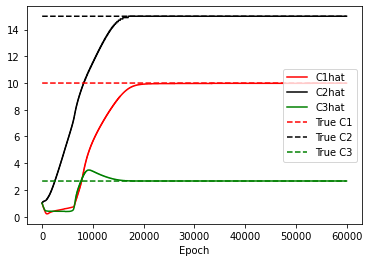

Predicting...
'predict' took 0.020893 s



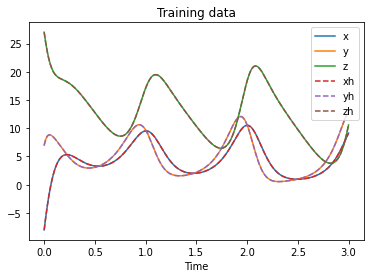

In [ ]:
# reopen saved data using callbacks in fnamevar
lines = open(fnamevar, "r").readlines()

# read output data in fnamevar (this line is a long story...)
Chat = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)

l, c = Chat.shape

plt.plot(range(l), Chat[:, 0], "r-")
plt.plot(range(l), Chat[:, 1], "k-")
plt.plot(range(l), Chat[:, 2], "g-")
plt.plot(range(l), np.ones(Chat[:, 0].shape) * C1true, "r--")
plt.plot(range(l), np.ones(Chat[:, 1].shape) * C2true, "k--")
plt.plot(range(l), np.ones(Chat[:, 2].shape) * C3true, "g--")
plt.legend(["C1hat", "C2hat", "C3hat", "True C1", "True C2", "True C3"], loc="right")
plt.xlabel("Epoch")
plt.show()


yhat = model.predict(observe_t)

plt.plot(observe_t, ob_y, "-", observe_t, yhat, "--")
plt.xlabel("Time")
plt.legend(["x", "y", "z", "xh", "yh", "zh"])
plt.title("Training data")
plt.show()
